In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))

In [2]:
import sys
sys.path.append(wd+"\\src\\")
from tube import Tube, InterpXY
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from pistonlayer import ElPistLayer, ElPistEOS
from powderlayer import Powder, PowderOvLayer, PowderBD
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq
import ipdb

### Debugging
https://appletree.or.kr/quick_reference_cards/Python/Python%20Debugger%20Cheatsheet.pdf

### Труба

In [5]:
tube_dict_sample = {
    'tube_points': [[0, 0.023], [1, 0.023], [1.3, 0.023*0.5], [1.5, 0.023*0.5]]
}

def get_tube(**tube_dict):
    if 'tube_points' not in tube_dict:
        raise Exception(f'В функции get_tube(**tube_dict) неправильные аргументы tube_dict={tube_dict}')
    xs, ds = [], []
    for x, d in tube_dict['tube_points']:
        xs.append(x)
        ds.append(d)
    return Tube(xs, ds)

get_tube(**tube_dict_sample)

Tube(xs=[0.0, 1.0, 1.3, 1.5], ds=[0.023, 0.023, 0.0115, 0.0115])

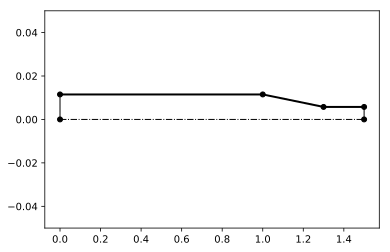

In [6]:
ax, fig = plt.subplots()
tube = get_tube(**tube_dict_sample)
tube.plot(ax, fig)
fig.set_ylim(-0.05,0.05)
plt.show()

### Граница

In [7]:
class Border(object):
    def __init__(self, 
                 lr_left: GasLayer, 
                 lr_right: GasLayer, 
                 mass: float, 
                 p_f:float, 
                 t_init=-1, 
                 w_border=0):
        
        self.lr_left= lr_left
        self.lr_right = lr_right
        self.mass = mass
        self.p_f = p_f
        self.t_init = t_init
        self.w_border = w_border
    
    def get_p_s_left(self):
        if self.lr_left is not None:
            return self.lr_left.get_p_right(), self.lr_left.S[-1]
        return 0, 0
        
    def get_p_s_right(self):
        if self.lr_right is not None:
            return self.lr_right.get_p_left(), self.lr_right.S[0]
        return 0, 0
    
    def get_right_layer_x1(self):
        return self.lr_left.xs_borders[-1] + self.w_border
    
    def get_v0(self):
        v0 = None
        if self.lr_left is not None:
            v0 = self.lr_left.Vs_borders[-1]
        if self.lr_right is not None:
            if v0 is not None:
                if abs(self.lr_right.xs_borders[0] - self.get_right_layer_x1()) < 1e-13:
                    raise AttributeError(f'Слои не синхронизированы по координатам!\n{self.lr_left}\n{self.lr_right}')
                vr = self.lr_right.Vs_borders[0]
                if abs(vr-v0) < 1e-13:
                    raise AttributeError(f'Слои не синхронизированы по скорости!\n{self.lr_left}\n{self.lr_right}')
            v0 = self.lr_right.Vs_borders[0]
        return v0
    
    def update_Vs(self, tau: float):
        v0 = self.get_v0()
        (pl, sl), (pr, sr) = self.get_p_left(), self.get_p_right()
        if abs(v0) < 1e-13 and abs(pl - pr) < self.p_f:
            v1 = 0
        else:
            a0 = (pl*sl - pr*sr)/self.mass
            v1 = v0 + tau*a0
        if self.lr_left is not None:
            self.lr_left.Vs_borders[-1] = v1
        if self.lr_right is not None:
            self.lr_right.Vs_borders[0] = v1
            
#     def plot(self, ax, fig, **kwargs):
#         n_points = kwargs.get('n_points', 10)
#         ix = np.linspace(a, b)
#         iy = func(ix)
#         verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
#         poly = Polygon(verts, facecolor='1', edgecolor='0.1', hatch=h)
#         ax.add_patch(poly)

### Пороховой слой

In [8]:
PowderBD().all_powders_dict['4\\7']

{'name': '4\\7',
 'f': 1.027,
 'etta': 0.228,
 'alpha_k': 1.008,
 'T_1': 3006.0,
 'ro': 1.6,
 'I_k': 0.32,
 'Z_k': 1.488,
 'k_1': 0.811,
 'lambda_1': 0.081,
 'k_2': 0.505,
 'lambda_2': -1.024,
 'k_f': 0.0003,
 'k_l': 0.0016}

In [9]:
powder_layer_dict_sample = {
    'type': 'PowderOvLayer',
    'powder': {
        'name': '4\\7',
        'f': 1.027,
        'etta': 0.228,
        'alpha_k': 1.008,
        'T_1': 3006.0,
        'ro': 1.6,
        'I_k': 0.32,
        'Z_k': 1.488,
        'k_1': 0.811,
        'lambda_1': 0.081,
        'k_2': 0.505,
        'lambda_2': -1.024,
        'k_f': 0.0003,
        'k_l': 0.0016
    },
    'omega': 35,  # грамм
    'delta': 700, # г/cm^3
    'p_0': 5e6, # начальное давление
    't_ign': 0.00001, # начало горения
    'u_0': 0,     #начальная скорость
}

calc_settings_sample = {
    'cell_dx': 0.0025,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {},
    'GridStrecher_kwargs': {}
}   

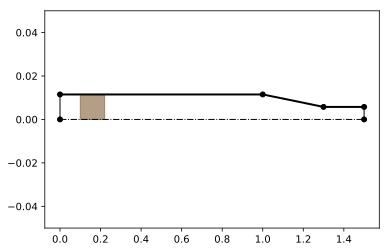

PowderOvLayer(n_cells=48); {'p_max':5000000.0, 'tau_min': 2.0077485058822994e-05, \
        'u_max': 0.0, 'cs_max': 124.87454021397153, 'dx_min': 0.0025071667153734045, 'x_1': 0.1, 'x_2': 0.2203440023379244,\
        'V_1':  0.0, 'V_2':  0.0  }{ 'powder': r'4\7', 'z_max': 0.0 }

In [10]:
tube=get_tube(**tube_dict_sample)
pl = PowderOvLayer.get_standart(tube, 0.1, powder_layer_dict_sample, calc_settings_sample)

fig, ax = plt.subplots()
tube.plot(fig, ax)
pl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

pl

### Газовый слой

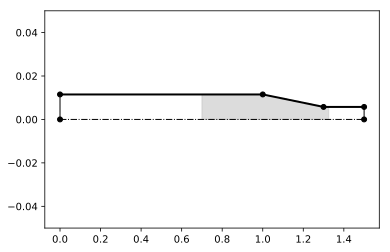

GasLayer(n_cells=250); {'p_max':10000000.0, 'tau_min': 6.400790476691708e-06, \
        'u_max': 0.0, 'cs_max': 390.8917435646241, 'dx_min': 0.002502016149625863, 'x_1': 0.7, 'x_2': 1.3255040374065175,\
        'V_1':  0.0, 'V_2':  0.0  }

In [11]:
gas_layer_dict_sample = {
    'type': 'gas',
    'name': 'air',
    'gamma': 1.4,
    'kappa': 0.0010838,
    'R': 287,
    'T_0': 300, # K
    'W_0': 0.0002,  # м^3 объем газа
    'p_0': 100e5, # начальное давление газа
    'u_0': 0,     #начальная скорость
}


tube=get_tube(**tube_dict_sample)
gl = GasLayer.get_standart(tube, 0.7, gas_layer_dict_sample, calc_settings_sample)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

gl

### Полиэтиленовый слой

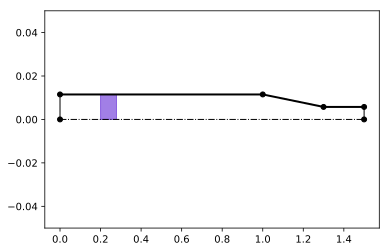

ElPistLayer(n_cells=31); {'p_max':100000.0, 'tau_min': 1.0980984547250666e-06, \
        'u_max': 0.0, 'cs_max': 2308.0384458555504, 'dx_min': 0.002534453450840024, 'x_1': 0.2, 'x_2': 0.2785680569760416,\
        'V_1':  0.0, 'V_2':  0.0  }

In [12]:
pist_layer_dict_sample = {
    'type': 'pist',
    'omega': 0.03,  # кг
    'p_0': 1e5, # начальное давление в полиэтилене
    'u_0': 0,     #начальная скорость
    'ElPistEOS_kwargs': dict(
        k=1.63098, 
        c_0=2308, 
        ro_0=919.03, 
        sigma_star=25.2, 
        k_0=0.054, 
        b_1=0.027, 
        b_2=0.00675, 
        tau_0=1.36, 
        mu=0.001, 
        tau_s=1,                 
        zeroP=False, 
        zeroE=True)
}


tube=get_tube(**tube_dict_sample)
pistl = ElPistLayer.get_standart(tube, 0.2, pist_layer_dict_sample, calc_settings_sample)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
pistl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

pistl 

0.0